In [12]:
import os
import cv2
import numpy as np
import onnxruntime as ort
from typing import List
from mean_average_precision import MetricBuilder
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt

In [15]:
class Yolov11_Onnx:
    def __init__(self, onnx_model_path: str, input_shape: tuple[int, int] = (640, 640), 
                 confidence_threshold: float = 0.5, nms_threshold: float = 0.65, 
                 label_list: List[str] = None):
        """Khởi tạo model ONNX"""
        self.onnx_model_path = onnx_model_path
        self.input_shape = input_shape
        self.confidence_threshold = confidence_threshold
        self.nms_threshold = nms_threshold
        self.label_list = label_list if label_list else ["Washer"]

        # Load mô hình ONNX
        self.session = ort.InferenceSession(self.onnx_model_path)
        
    def _preprocessing(self, frame):
        """Tiền xử lý ảnh"""
        original_height, original_width = frame.shape[:2]
        self.resize_ratio_w = original_width / self.input_shape[0]
        self.resize_ratio_h = original_height / self.input_shape[1]

        # Resize ảnh
        input_img = cv2.resize(frame, self.input_shape)
        input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)  # Chuyển sang RGB
        input_img = input_img.transpose(2, 0, 1)  # Đổi từ HWC -> CHW
        input_img = np.ascontiguousarray(input_img) / 255.0
        input_tensor = input_img[np.newaxis, :, :, :].astype(np.float32)

        return input_tensor
    
    def _postprocessing(self, output):
        """Hậu xử lý kết quả mô hình"""
        output = np.array(output)
        x_center, y_center, w, h = output[0, 0, :4, :]
        confidence = output[0, 0, 4:, :]
                       
        class_id = np.argmax(confidence, axis=0)
        max_class_prob = np.max(confidence, axis=0)

        # Lọc các bounding box có độ tin cậy lớn hơn ngưỡng
        mask = max_class_prob > self.confidence_threshold
        detections = [
            [
                x_center[i] * self.resize_ratio_w,  
                y_center[i] * self.resize_ratio_h,  
                w[i] * self.resize_ratio_w,         
                h[i] * self.resize_ratio_h,         
                class_id[i],  
                max_class_prob[i]
            ]
            for i in range(len(mask)) if mask[i]
        ]

        # Áp dụng NMS để loại bỏ box trùng lặp
        if detections:
            boxes = np.array([[int(d[0] - d[2] / 2), int(d[1] - d[3] / 2), d[2], d[3]] for d in detections])
            confidences = np.array([d[5] for d in detections])
            indices = cv2.dnn.NMSBoxes(boxes.tolist(), confidences.tolist(), self.confidence_threshold, self.nms_threshold)
      
            if len(indices) > 0:
                detections = [detections[i] for i in indices.flatten()]

        return detections
    
    def drawbox(self, frame, detections):
        """Vẽ bounding box lên ảnh"""
        num_object = 0
        for x_center, y_center, w, h, class_id, conf in detections:
            x, y = x_center - w / 2, y_center - h / 2
            x_max, y_max = x_center + w / 2, y_center + h / 2
            class_name = self.label_list[class_id]

            if class_name == "Washer":
                num_object += 1
     

            cv2.rectangle(frame, (int(x), int(y)), (int(x_max), int(y_max)), (0, 255, 0), 2)
            cv2.putText(frame, class_name, (int(x), int(y) - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

        cv2.putText(frame, f"Object(s): {num_object}", (10, 30), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        return frame

In [3]:
def save_detections(image_path, detections, output_folder):
    """Lưu kết quả phát hiện vào file .txt"""
    os.makedirs(output_folder, exist_ok=True)  
    base_name = os.path.basename(image_path)  
    txt_path = os.path.join(output_folder, f"{os.path.splitext(base_name)[0]}.txt")

    with open(txt_path, "w") as f:
        for x_center, y_center, w, h, class_id, conf in detections:
            x_min, y_min = x_center - w / 2, y_center - h / 2
            x_max, y_max = x_center + w / 2, y_center + h / 2
            f.write(f"{x_min:.2f} {y_min:.2f} {x_max:.2f} {y_max:.2f} {class_id} {conf:.4f}\n")

    print(f"Saved: {txt_path}")

In [17]:
def process_folder(folder_path, model, output_folder):
    """Duyệt toàn bộ ảnh trong thư mục và lưu kết quả"""
    image_extensions = (".jpg", ".png", ".jpeg")
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(image_extensions)]

    for image_name in image_files:
        image_path = os.path.join(folder_path, image_name)
        frame = cv2.imread(image_path)
        if frame is None:
            print(f"Không thể đọc ảnh: {image_path}")
            continue

        input_tensor = model._preprocessing(frame)
        input_name = model.session.get_inputs()[0].name
        output = model.session.run(None, {input_name: input_tensor})

        detections = model._postprocessing(output)
        save_detections(image_path, detections, output_folder)

        result_frame = model.drawbox(frame, detections)
    #     cv2.imshow("Detection Result", result_frame)
    #     cv2.waitKey(1)  # Hiển thị nhanh từng ảnh

    # cv2.destroyAllWindows()  

In [5]:
def convert_gt_format(gt_line, img_width = 640, img_height = 640):
    """Chuyển đổi định dạng ground truth từ YOLO sang định dạng x_min, y_min, x_max, y_max"""
    class_id, x_center, y_center, w, h = list(map(float, gt_line.strip().split()))
    x_min = (x_center - w / 2) * img_width
    y_min = (y_center - h / 2) * img_height
    x_max = (x_center + w / 2) * img_width
    y_max = (y_center + h / 2) * img_height
    
    return [x_min, y_min, x_max, y_max, int(class_id), 0, 0]


In [6]:
def computeMAP(gt_path, pred_path):    
    metric_fn = MetricBuilder.build_evaluation_metric("map_2d", async_mode=True, num_classes=2)
    gt_files = [f for f in os.listdir(gt_path) if f.lower().endswith(".txt")]
    pred_files = [f for f in os.listdir(pred_path) if f.lower().endswith(".txt")]
    
    for gt_file, pred_file in zip(gt_files, pred_files):
        gt_file_path = os.path.join(gt_path, gt_file)
        pred_file_path = os.path.join(pred_path, pred_file)
        
        with open(gt_file_path, "r") as f:
            gt_lines = f.readlines()
        with open(pred_file_path, "r") as f:
            pred_lines = f.readlines()
        
        gt_boxes = [convert_gt_format(line) for line in gt_lines]
        pred_boxes = [
            [float(x) for x in line.strip().split()[:-2]] +  # Lấy x_min, y_min, x_max, y_max (float)
            [int(line.strip().split()[-2])] +                # class_id (int)
            [float(line.strip().split()[-1])]                # confidence (float)
            for line in pred_lines
        ]

        gt_boxes = np.array(gt_boxes)
        pred_boxes = np.array(pred_boxes)
        
        metric_fn.add(pred_boxes, gt_boxes)
        
    metric1 = metric_fn.value(iou_thresholds=0.5)
    metric2 = metric_fn.value(iou_thresholds=np.arange(0.5, 1, 0.05))
    
    return metric1['mAP'], metric2['mAP']

In [13]:
def run1():
    model_path = "D:/code/projectTest/computer_vision/project2/best.onnx"
    image_path = "D:/code/projectTest/computer_vision/project2/dataset/images/2hnx6rm_jpg.rf.e90f39843813b92abef80e4acfbe6083.jpg"

    

    yolov11 = Yolov11_Onnx(model_path)
    frame = cv2.imread(image_path)
    if frame is None:
        print(f"Không thể đọc ảnh: {image_path}")


    input_tensor = yolov11._preprocessing(frame)
    
    input_name = yolov11.session.get_inputs()[0].name
    output = yolov11.session.run(None, {input_name: input_tensor})

    detections = yolov11._postprocessing(output)

    result_frame = yolov11.drawbox(frame, detections)
    result_frame_rgb = cv2.cvtColor(result_frame, cv2.COLOR_BGR2RGB)

    plt.imshow(result_frame_rgb)
    plt.axis("off")
    plt.title("Detection Result")
    plt.show()
    # cv2.imshow("Detection Result", result_frame)
    # cv2.waitKey(0) 

In [18]:

def run2():
    model_path = "D:/code/projectTest/computer_vision/project2/best.onnx"
    input_folder = "D:/code/projectTest/computer_vision/project2/dataset/images"
    output_folder = "D:/code/projectTest/computer_vision/project2/detections"
    
    yolov11 = Yolov11_Onnx(model_path)
    process_folder(input_folder, yolov11, output_folder)

In [21]:

def run3():
    gt_path = "D:/code/projectTest/computer_vision/project2/dataset/labels"
    pred_path_py = "D:/code/projectTest/computer_vision/project2/detections"
        
    # Tính mAP
    mAP1, mAP2 = computeMAP(gt_path, pred_path_py)

    values = [mAP1, mAP2]
    plt.bar(["Python (0.5)", "Python (0.5-0.95)"], values)
    plt.ylabel("mAP")
    
    for i, v in enumerate(values):
        plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=12, fontweight='bold')

    plt.show()
    

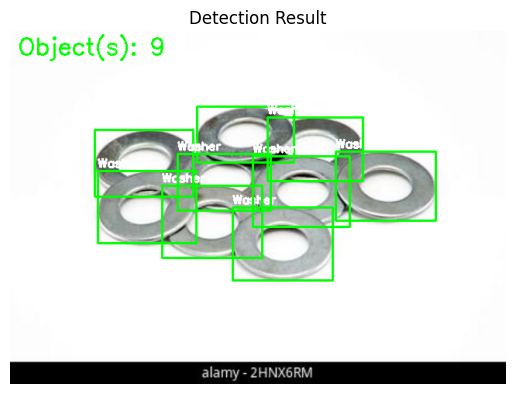

In [23]:

def main():
    # Nhận diện đơn ảnh
    run1()
    
    # # Nhận diện folder
    # run2()
    
    # Tính mAP
    # run3()
    
if __name__ == "__main__":
    main()